## Import Library

In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

## Define Constants

In [12]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [13]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [14]:
df.head()

,filename,category
0,cat.48.jpg,0
1,cat.64.jpg,0
2,cat.94.jpg,0
3,cat.53.jpg,0
4,cat.51.jpg,0


In [16]:
df.tail()

,filename,category
397,dog.140.jpg,1
398,dog.119.jpg,1
399,dog.108.jpg,1
400,dog.154.jpg,1
401,dog.129.jpg,1


## See Total in count

<Axes: xlabel='category'>

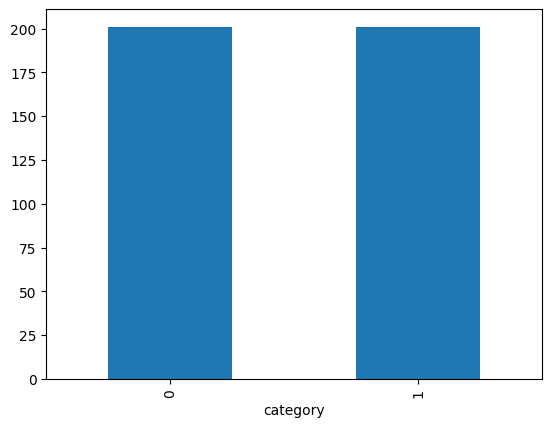

In [17]:
df['category'].value_counts().plot.bar()

From our data we have 200 cats and 200 dogs

## See sample image

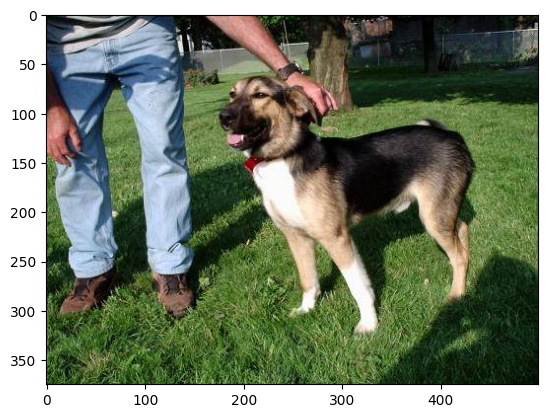

In [18]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

## Callbacks
Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [20]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Prepare data
Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [21]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [22]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

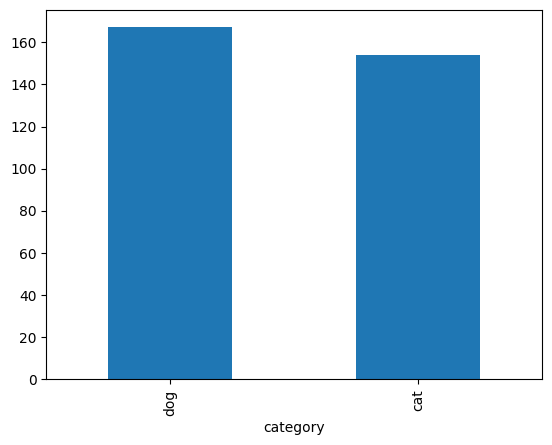

In [23]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

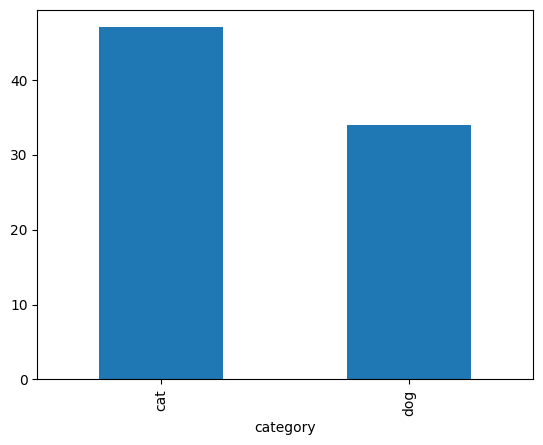

In [24]:
validate_df['category'].value_counts().plot.bar()

In [25]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Traning Generator

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 321 validated image filenames belonging to 2 classes.


## Validation generator

In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 81 validated image filenames belonging to 2 classes.


## See how our generator work

In [28]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


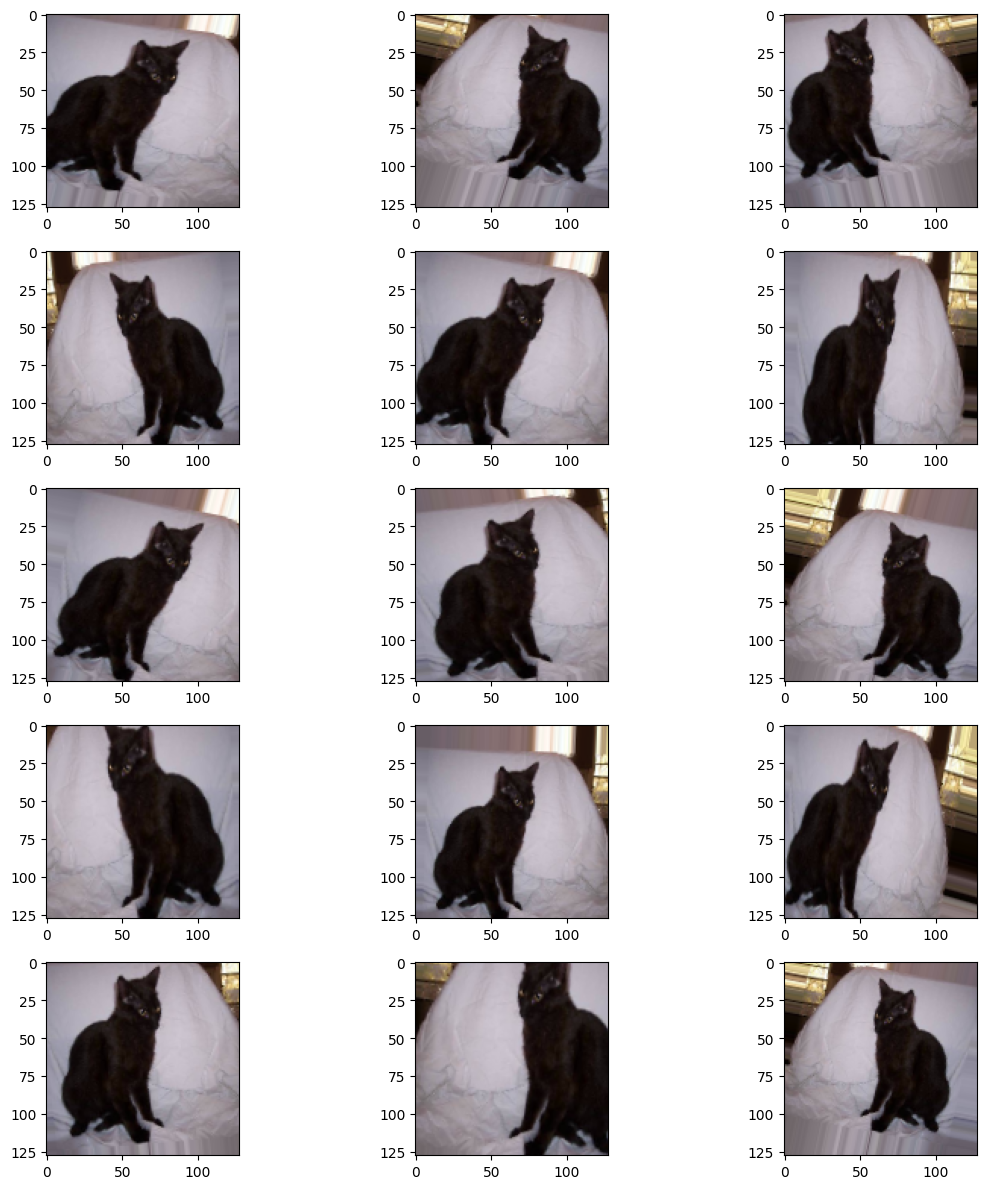

In [29]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seems to be nice
# fit model

In [30]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

Epoch 1/50
21/21 [==============================] - 296s 14s/step - loss: 1.7098 - accuracy: 0.5686 - val_loss: 0.8362 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 3s 137ms/step - loss: 1.1877 - accuracy: 0.5915 - val_loss: 0.7836 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.1783 - accuracy: 0.5948
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 3s 151ms/step - loss: 1.1783 - accuracy: 0.5948 - val_loss: 1.0116 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 4s 180ms/step - loss: 0.9161 - accuracy: 0.6063 - val_loss: 0.7334 - val_accuracy: 0.5467 - lr: 5.0000e-04
Epoch 5/50
21/21 [==============================] - ETA: 0s - loss: 0.8320 - accuracy: 0.6209
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
21/21 [==============================] - 3s 134

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Visualizing training

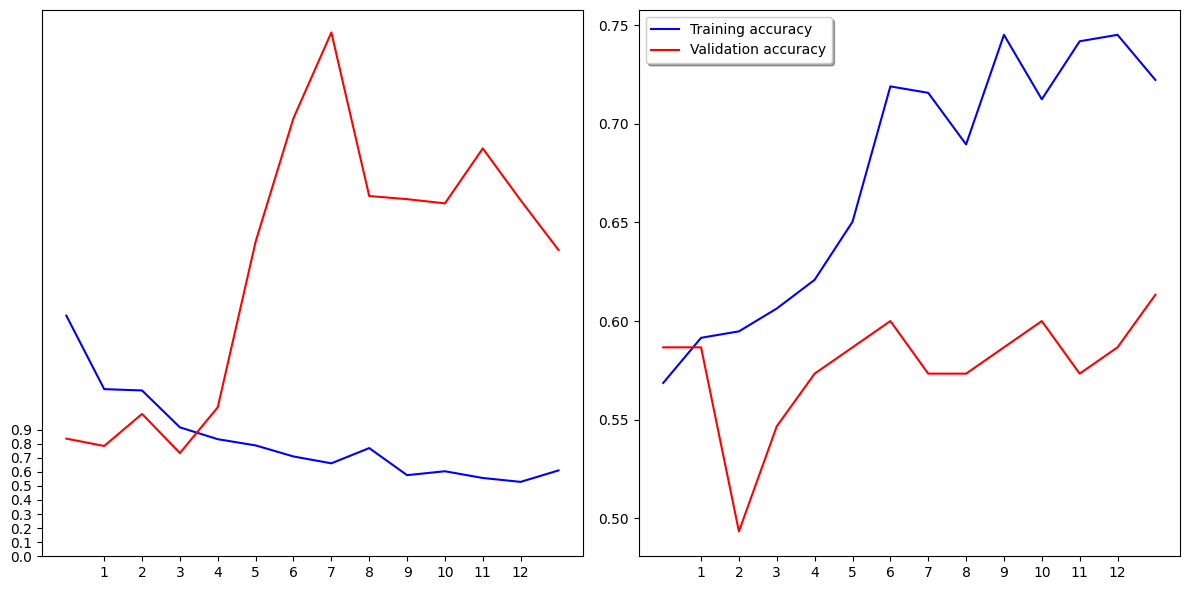

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 13, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 13, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [36]:
from google.colab.patches import cv2_imshow
import os
import random
import cv2

1/1 [==============================] - 0s 31ms/step
cat


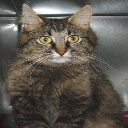

1/1 [==============================] - 0s 17ms/step
dog


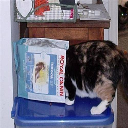

1/1 [==============================] - 0s 17ms/step
dog


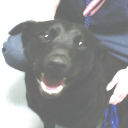

1/1 [==============================] - 0s 17ms/step
dog


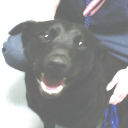

1/1 [==============================] - 0s 17ms/step
dog


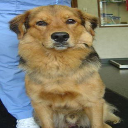

1/1 [==============================] - 0s 42ms/step
dog


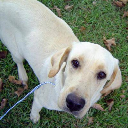

1/1 [==============================] - 0s 23ms/step
dog


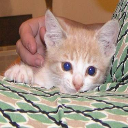

1/1 [==============================] - 0s 20ms/step
dog


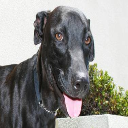

1/1 [==============================] - 0s 23ms/step
dog


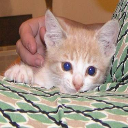

1/1 [==============================] - 0s 17ms/step
dog


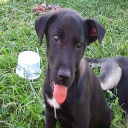

In [40]:
for i in range(10):
    all_test_images = os.listdir('test')
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'test/{random_image}')
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))

    org = img.copy()
    img = img.reshape(1, 128, 128, 3)

    pred = model.predict(img)
    print(['cat', 'dog'][int(pred[0][0])])
    cv2_imshow(org)

In [ ]:
!pip install gradio==3.50

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os
os.chdir("//content/drive/MyDrive/Deep Learning Projects/Cat_Dog_Classifiyer")

In [44]:
from tensorflow.keras.models import load_model
import cv2
import gradio as gr

In [45]:
model = load_model("model.h5")

In [46]:
def predict(image):
    img = cv2.resize(image,(128,128))
    img = img.reshape(1,128,128,3)
    preds = model.predict(img)[0]
    result = dict()
    result["Cat"] = round(float(list(preds)[0]), 3)
    result["Dog"] = round(float(list(preds)[1]), 3)

    return result

In [47]:
im = gr.Image()
label = gr.Label(num_top_classes=2)

gr.Interface(fn=predict,
             inputs=im,
             outputs=label,
             title="CNN Demo").launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4a68f05d3a23a8171c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 112ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4a68f05d3a23a8171c.gradio.live
